In [9]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d
from wrf_io import postproc

from MITRotor import BEM, IEA10MW, BEMGeometry, NoTipLoss, KraghAerodynamics, ConstantInduction, NoTangentialInduction

In [10]:
fontsize = 24
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

In [11]:
nElements = 26
nSections = 158

In [12]:
casenames = [r's0_v4', r'sn2_v2', r's0_v2',r's2_v2', r'sn4_v0', r'sn2_v0', r's0_v0', r's2_v0', r's4_v0', r'sn2_vn2', r's0_vn2', r's2_vn2', r's0_vn4']
# casenames = [r's0_v4']


wrfles_data = []
# wrfles_wind = []
for count, name in enumerate(casenames):
    wrfles_data.append(dict(np.load('/scratch/09909/smata/wrf_les_sweep/runs/10MW/gad_sweep/'+casenames[count]+'_new.npz')))

In [13]:
file_list = glob.glob("/scratch/09909/smata/wrf_les_sweep/runs/10MW/gad_sweep/*/input_sounding")

data = postproc.extract_sounding(file_list,casenames)

t = np.linspace(0,2*np.pi,nSections)
r = np.linspace(0,1,nElements)

R, T = np.meshgrid(r, t)

X = R * np.sin(T)
Y = (R * np.cos(T)) * wrfles_data[0]['diameter']/2 + 378

In [14]:
rotor = IEA10MW()

bem = BEM(rotor=rotor, geometry=BEMGeometry(Nr=nElements, Ntheta=nSections), aerodynamic_model=KraghAerodynamics(), tiploss_model=NoTipLoss(), momentum_model=ConstantInduction(), tangential_induction_model=NoTangentialInduction())

pitch, tsr, yaw = np.deg2rad(0), 10.634, np.deg2rad(0.0)

In [18]:
power     = np.zeros_like(casenames, dtype='float')
thrust    = np.zeros_like(casenames, dtype='float')
induction = np.zeros_like(casenames, dtype='float')

for count in range(len(casenames)):

    u_func = interp1d(data[casenames[count]][:,0], data[casenames[count]][:,1], kind='linear')
    v_func = interp1d(data[casenames[count]][:,0], data[casenames[count]][:,2], kind='linear')

    u_inf = u_func(Y)
    v_inf = v_func(Y)

    u = np.mean(wrfles_data[count]['u'], axis = 0)
    v = np.mean(wrfles_data[count]['v'], axis = 0)

    wdir = np.arctan2(v,u)

    U = (u**2 + v**2)**(1/2)

    sol = bem(pitch, tsr, yaw, v_inf=7.0, U = U/7, wdir = wdir)

    power[count] = sol.power()
    thrust[count] = sol.thrust()
    induction[count] = postproc.rotor_average(1 - u / u_inf.T, (wrfles_data[count]['rOverR']), t)

In [19]:
power     = postproc.per_error(power, power[6])
thrust    = postproc.per_error(thrust, thrust[6])
induction = postproc.per_error(induction, induction[6])

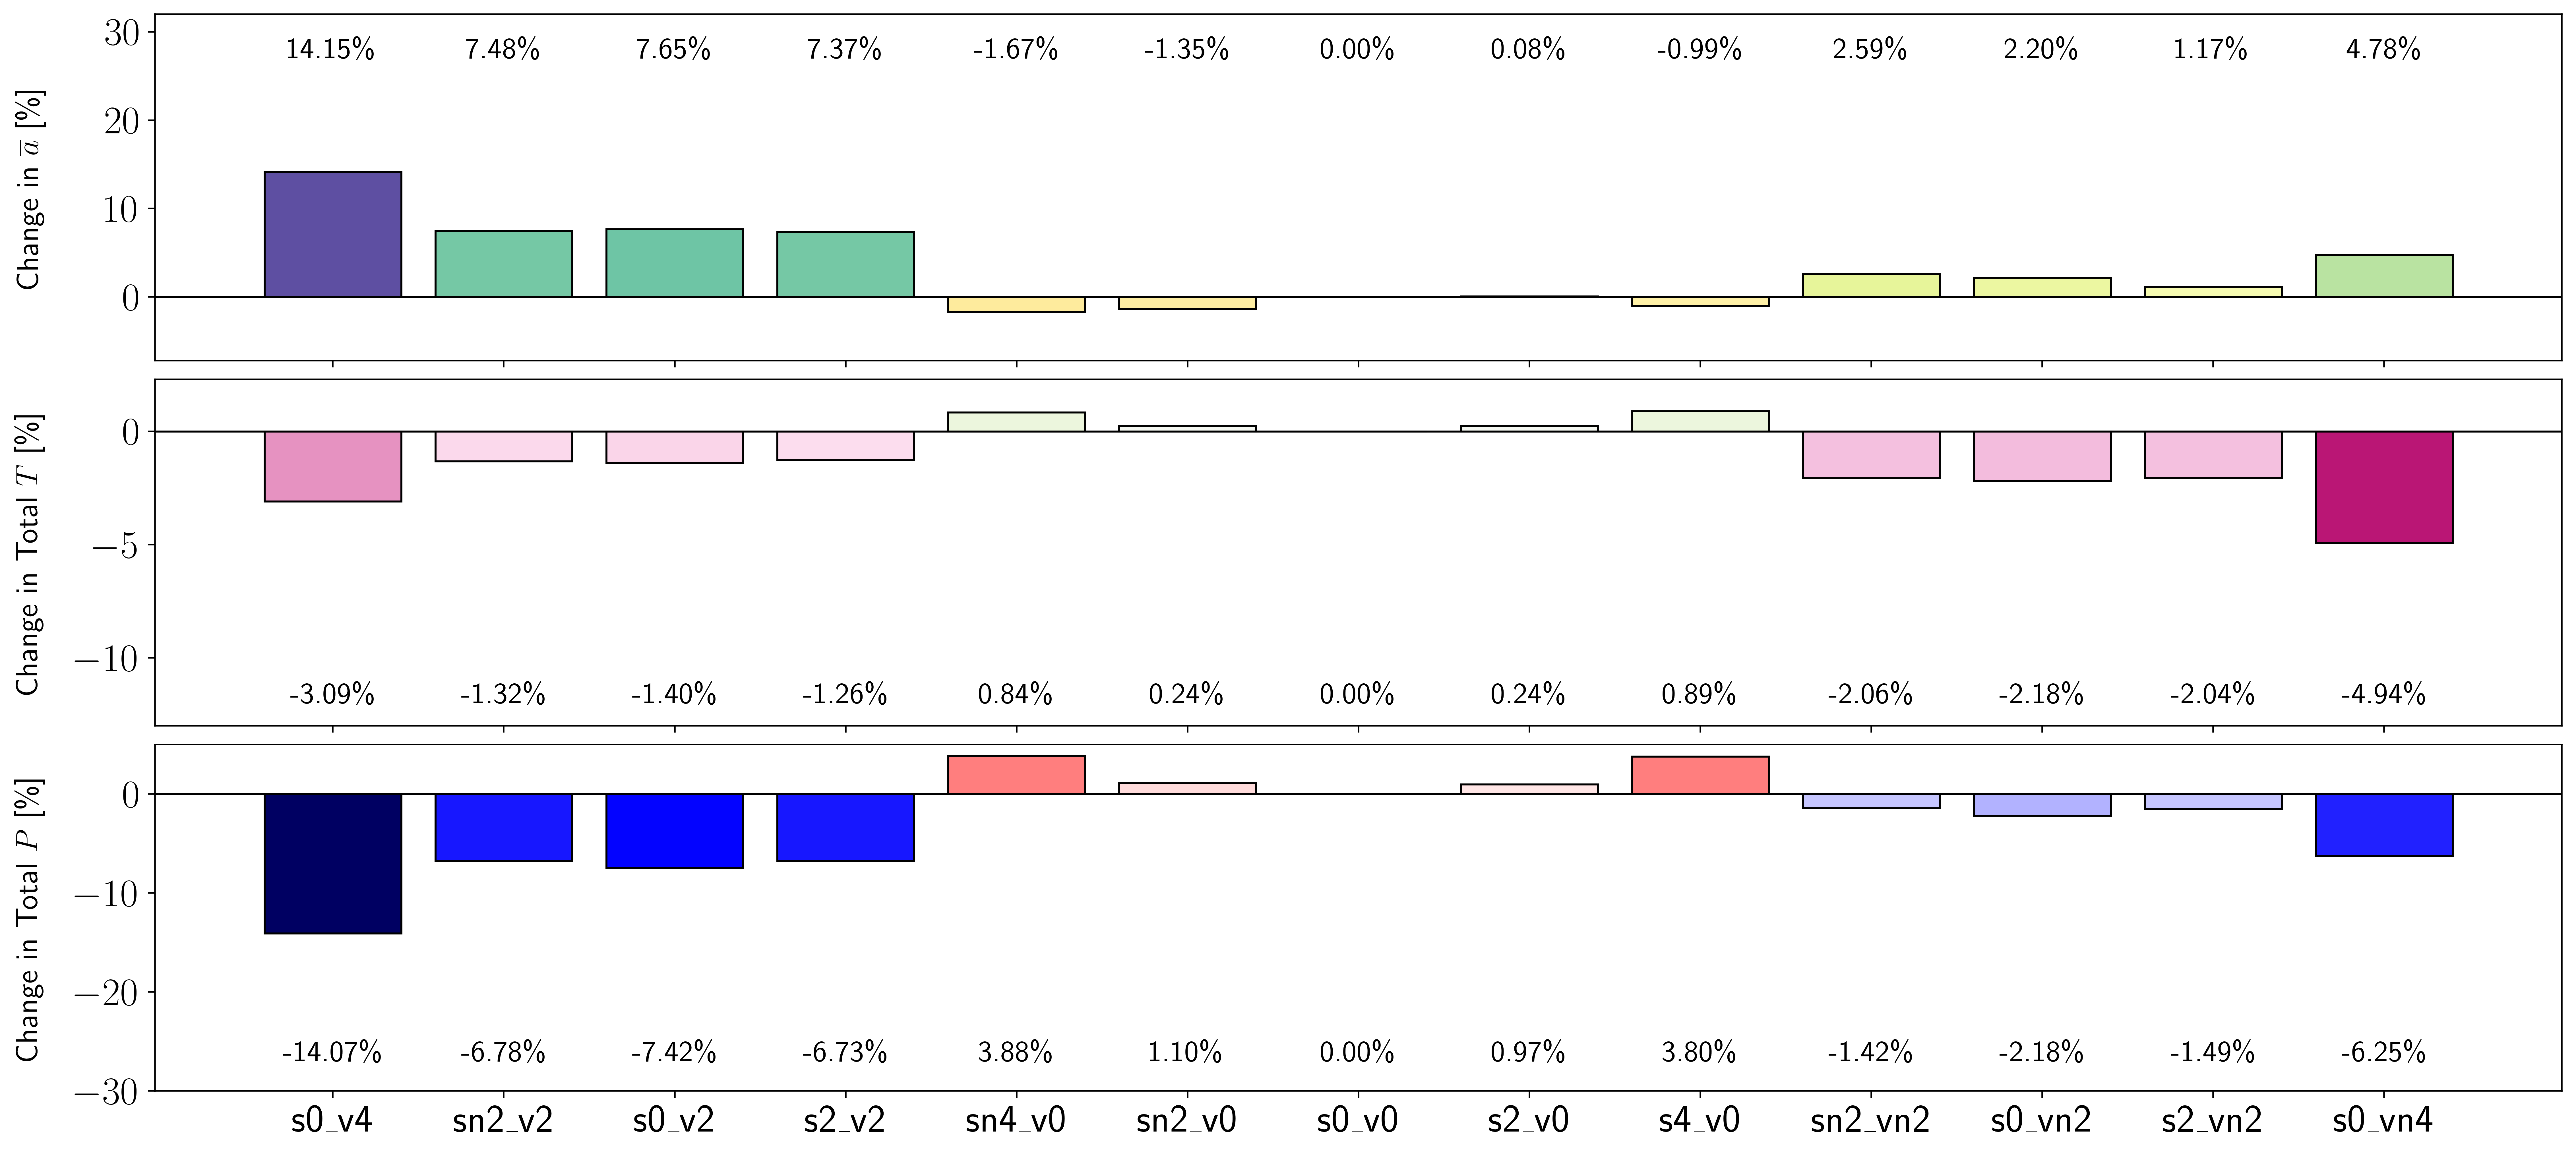

In [21]:
n_levels = 100

pow_levels = plt.colormaps['seismic'].resampled(n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-15, vmax=15)  # Normalize power to [0, 1]
pow_cmap = [pow_levels(int(norm(p) * (n_levels - 1))) for p in power]  # Map power to discrete colors

thr_levels = plt.colormaps['PiYG'].resampled(n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-6, vmax=6)  # Normalize power to [0, 1]
thr_cmap = [thr_levels(int(norm(t) * (n_levels - 1))) for t in thrust]  # Map power to discrete colors

ind_levels = plt.colormaps['Spectral'].resampled(n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-13, vmax=13)  # Normalize power to [0, 1]
ind_cmap = [ind_levels(int(norm(a) * (n_levels - 1))) for a in induction]  # Map power to discrete colors


width = 0.75
alpha = 1.0

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18, 8), sharex=True, constrained_layout = True)
ax[0].axhline(0, color='black', linestyle='solid', linewidth=1)
ax[1].axhline(0, color='black', linestyle='solid', linewidth=1)
ax[2].axhline(0, color='black', linestyle='solid', linewidth=1)
# ax[3].axhline(0, color='black', linestyle='solid', linewidth=1)

ind = np.arange(len(casenames))

for count in range(len(casenames)):

    # induction
    ax[0].bar(ind[count], induction[count], color=ind_cmap[count], edgecolor='black', alpha=alpha)
    ax[0].set_ylabel(r'Change in ${\overline{a}}$ [\%]', fontsize=fontsize*0.65, labelpad=30)
    ax[0].text(ind[count], 27, f'{induction[count]:0.2f}\%', ha='center', fontsize=15)
    ax[0].set_ylim([-7.2,32])

    # thrust
    ax[1].bar(ind[count], thrust[count], color=thr_cmap[count], edgecolor='black', alpha=alpha)
    ax[1].set_ylabel(r'Change in Total $T$ [\%]', fontsize=fontsize*0.65, labelpad=15)
    ax[1].text(ind[count], -12, f'{thrust[count]:0.2f}\%', ha='center', fontsize=15)
    ax[1].set_ylim([-13,2.3])

    # power
    ax[2].bar(ind[count], power[count], color=pow_cmap[count], edgecolor='black', alpha=alpha)
    ax[2].set_xticks(ind)
    ax[2].set_xticklabels(casenames)
    ax[2].set_ylabel(r'Change in Total $P$ [\%]', fontsize=fontsize*0.65, labelpad=15)
    ax[2].text(ind[count], -27, f'{power[count]:0.2f}\%', ha='center', fontsize=15)
    ax[2].set_ylim([-30,5])